In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/drone_sky_aircraft.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [3]:
# Get regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/DominikZurawski/PyTorch_exercises
    !mv PyTorch_exercises/going_modular .
    !mv PyTorch_exercises/helper_functions.py .
    !rm -rf PyTorch_exercises
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'PyTorch_exercises'...
remote: Enumerating objects: 1780, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1780 (delta 2), reused 0 (delta 0), pack-reused 1775 (from 3)
Receiving objects: 100% (1780/1780), 203.13 MiB | 20.35 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [4]:
 # Make sure we have a GPU
 device = "cuda" if torch.cuda.is_available() else "cpu"
 device

'cuda'

In [5]:
train_dir = "data/train"
test_dir = "data/test"

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 79.5MB/s]


In [7]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408,
              out_features=6))

In [9]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=6,
                                                      seed=42)

In [11]:
from torchinfo import summary

# # Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 6]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [12]:
# Setup DataLoaders
from going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [13]:
from going_modular import engine
from going_modular.utils import create_writer

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=25,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                writer=create_writer(experiment_name="EffNetB2",
                                       model_name="EffNetB2",
                                       extra=f"epochs"))

[INFO] Created SummaryWriter, saving to: runs/2025-04-04/EffNetB2/EffNetB2/epochs...


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7493 | train_acc: 0.7892 | test_loss: 0.3747 | test_acc: 0.9201
Epoch: 2 | train_loss: 0.4164 | train_acc: 0.8732 | test_loss: 0.2859 | test_acc: 0.9302
Epoch: 3 | train_loss: 0.3517 | train_acc: 0.8861 | test_loss: 0.2453 | test_acc: 0.9353
Epoch: 4 | train_loss: 0.3102 | train_acc: 0.8981 | test_loss: 0.2353 | test_acc: 0.9331
Epoch: 5 | train_loss: 0.3098 | train_acc: 0.8948 | test_loss: 0.2155 | test_acc: 0.9346
Epoch: 6 | train_loss: 0.2920 | train_acc: 0.9023 | test_loss: 0.2032 | test_acc: 0.9382
Epoch: 7 | train_loss: 0.2810 | train_acc: 0.9028 | test_loss: 0.1933 | test_acc: 0.9455
Epoch: 8 | train_loss: 0.2642 | train_acc: 0.9094 | test_loss: 0.1996 | test_acc: 0.9382
Epoch: 9 | train_loss: 0.2681 | train_acc: 0.9091 | test_loss: 0.1900 | test_acc: 0.9404
Epoch: 10 | train_loss: 0.2693 | train_acc: 0.9061 | test_loss: 0.1855 | test_acc: 0.9433
Epoch: 11 | train_loss: 0.2652 | train_acc: 0.9076 | test_loss: 0.1834 | test_acc: 0.9426
Epoch: 12 | train_l

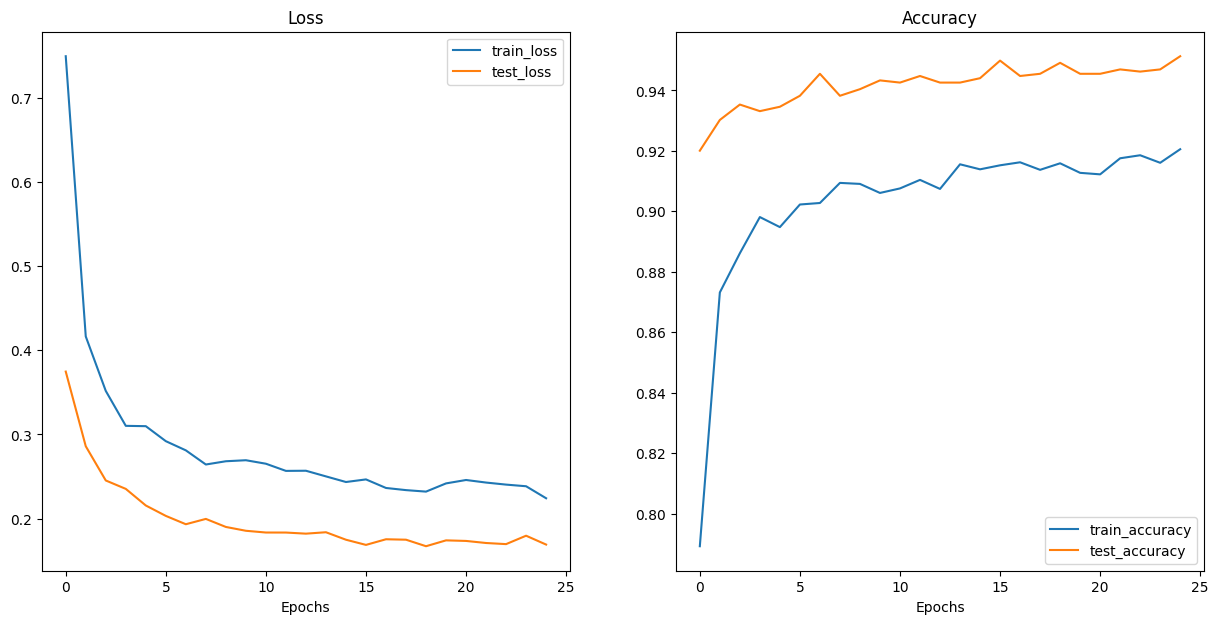

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [15]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_feature_extractor_aircraft.pth")

[INFO] Saving model to: models/effnetb2_feature_extractor_aircraft.pth


In [17]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
pretrained_effnetb2_model_size = Path("models/effnetb2_feature_extractor_aircraft.pth").stat().st_size // (1024*1024)

# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.16909624620876818,
 'test_acc': 0.9513081395348837,
 'number_of_parameters': 7709448,
 'model_size (MB)': 29}

In [19]:
from google.colab import files

# Ścieżka do zapisanego modelu
model_path = "models/effnetb2_feature_extractor_aircraft.pth"

# Pobierz model na dysk lokalny
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>